<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_COLAB_Experiemnts/blob/master/optimization_practice/jobs_schedule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimize Job Schedules

* [Problem Statement][1]
* Learn to use disjunctive in pyomo, try out my solutions

[1]:https://github.com/jckantor/ND-Pyomo-Cookbook/blob/main/notebooks/04.02-Machine-Bottleneck.ipynb

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *
from pyomo.gdp import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.4 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5.
(Reading database ... 128126 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-1_amd64.deb ...
Unpacking coinor-libcoinutils3v5 (2.11.4+repack1-1) ...
Selecting previously unselected package coinor-libosi1v5.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-1_amd64.deb ...
Unpacking coinor-libosi1v5 (0.108.6+repack1-1) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-2_amd64.deb ...
Unpacking coinor-libcgl1 (0.60.3+repack1-2) ...
Selecting previously unselecte

In [2]:
# GANTT graph drawing copied from https://github.com/jckantor/ND-Pyomo-Cookbook/blob/main/notebooks/04.02-Machine-Bottleneck.ipynb
def gantt(JOBS, SCHEDULE={}):
    bw = 0.3
    plt.figure(figsize=(12, 0.7*(len(JOBS.keys()))))
    idx = 0
    for j in sorted(JOBS.keys()):
        x = JOBS[j]['release']
        y = JOBS[j]['due']
        plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='green', alpha=0.7)
        if j in SCHEDULE.keys():
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='deeppink', alpha=0.9)
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        idx += 1

    plt.ylim(-0.5, idx-0.5)
    plt.title('Job Schedule')
    plt.xlabel('Time')
    plt.ylabel('Jobs')
    plt.yticks(range(len(JOBS)), JOBS.keys())
    plt.grid()
    xlim = plt.xlim()
    
    if SCHEDULE:
        for j in SCHEDULE.keys():
            if 'machine' not in SCHEDULE[j].keys():
                SCHEDULE[j]['machine'] = 1
        MACHINES = sorted(set([SCHEDULE[j]['machine'] for j in SCHEDULE.keys()]))

        plt.figure(figsize=(12, 0.7*len(MACHINES)))
        for j in sorted(SCHEDULE.keys()):
            idx = MACHINES.index(SCHEDULE[j]['machine'])
            x = SCHEDULE[j]['start']
            y = SCHEDULE[j]['finish']
            plt.fill_between([x,y],[idx-bw,idx-bw],[idx+bw,idx+bw], color='mediumorchid')
            plt.plot([x,y,y,x,x], [idx-bw,idx-bw,idx+bw,idx+bw,idx-bw],color='k')
            plt.text((SCHEDULE[j]['start'] + SCHEDULE[j]['finish'])/2.0,idx,
                'Job ' + j, color='white', weight='bold',
                horizontalalignment='center', verticalalignment='center')
        plt.xlim(xlim)
        plt.ylim(-0.5, len(MACHINES)-0.5)
        plt.title('Machine Schedule')
        plt.yticks(range(len(MACHINES)), MACHINES)
        plt.ylabel('Machines')
        plt.grid()

In [3]:
JOBS = {
    'A': {'release': 2, 'duration': 5, 'due': 10},
    'B': {'release': 5, 'duration': 6, 'due': 21},
    'C': {'release': 4, 'duration': 8, 'due': 15},
    'D': {'release': 0, 'duration': 4, 'due': 10},
    'E': {'release': 0, 'duration': 2, 'due':  5},
    'F': {'release': 8, 'duration': 3, 'due': 15},
    'G': {'release': 9, 'duration': 2, 'due': 22},
}

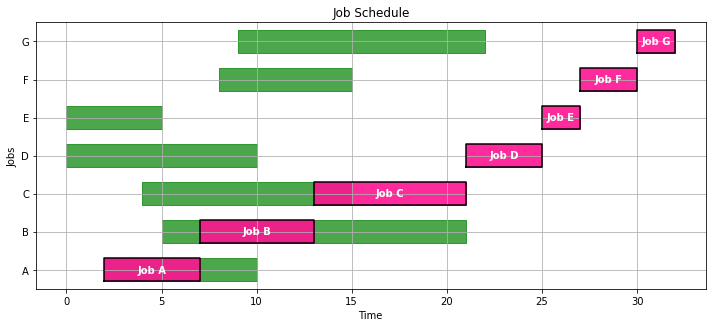

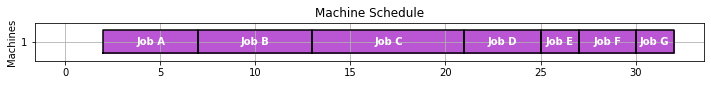

In [4]:
# do 1 job at a time, finish 1 after another with optimization
def schedule(JOBS, order=sorted(JOBS.keys())):
    """Schedule a dictionary of JOBS on a single machine in a specified order."""
    start = 0
    finish = 0
    SCHEDULE = {}
    for job in order:
        start = max(JOBS[job]['release'], finish)
        finish = start + JOBS[job]['duration']
        SCHEDULE[job] = {'start': start, 'finish': finish}
    return SCHEDULE   

SCHEDULE = schedule(JOBS)
gantt(JOBS, SCHEDULE)

In [11]:
def opt_output(JOBS, SCHEDULE):
  output = {}
  output['total_span'] = max(SCHEDULE[job]['finish'] for job in SCHEDULE.keys())
  overdue_lst = [SCHEDULE[job]['finish'] - JOBS[job]['due'] for job in SCHEDULE.keys()]
  output['max_overdue'] = max(overdue_lst)
  output['total_overdue'] = sum([overdue for overdue in overdue_lst if overdue > 0])
  output['overdue_ct'] = sum([overdue > 0 for overdue in overdue_lst])
  output['ontime_ct'] = sum([overdue <= 0 for overdue in overdue_lst])

  return output

## Single Thread

* All jobs are execuated by 1 thread

#### Lessons Learned
* To minimize overdue means to minimize the sum of positive overdues. We can replace variable `early` with negative overdue but this could make the objective become a nonlinear problem.
* Sometimes, to bring in a new variable while adjusting the domain of these variables, might convert a nonlinear problem to linear, such as bring in `early` and have nonnegative overdue only.

In [31]:
m = ConcreteModel()
m.J = Set(initialize=JOBS.keys())
m.PAIRS = Set(initialize=m.J * m.J, dimen=2, filter=lambda m, j, k: j < k)

max_time = max(JOBS[j]['release'] for j in m.J) + sum(JOBS[j]['duration'] for j in m.J)  # upper bound to finish all jobs

m.start = Var(m.J, domain=NonNegativeReals, bounds=(0, max_time))
m.overdue = Var(m.J, domain=Reals, bounds=(0, max_time))
m.early = Var(m.J, domain=NonNegativeReals, bounds=(0, max_time))

m.obj = Objective(expr = sum(m.overdue[j] for j in m.J), sense=minimize)

m.c1 = Constraint(m.J, rule=lambda m, j: m.start[j] >= JOBS[j]['release'])
m.c2 = Constraint(m.J, rule=lambda m, j: m.start[j] + JOBS[j]['duration'] + m.early[j] == JOBS[j]['due'] + m.overdue[j])
m.c3 = Constraint(m.J, rule=lambda m, j: m.start[j] + JOBS[j]['duration'] <= max_time)
m.c4 = Disjunction(m.PAIRS, rule=lambda m, j, k: [m.start[j] + JOBS[j]['duration'] <= m.start[k],
                                                m.start[k] + JOBS[k]['duration'] <= m.start[j]])  # only 1 job each time

TransformationFactory('gdp.chull').apply_to(m)
SolverFactory('cbc').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 16.0
  Upper bound: 16.0
  Number of objectives: 1
  Number of constraints: 133
  Number of variables: 77
  Number of binary variables: 42
  Number of integer variables: 42
  Number of nonzeros: 7
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.64
  Wallclock time: 0.66
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

{'total_span': 30.0,
 'max_overdue': 15.0,
 'total_overdue': 16.0,
 'overdue_ct': 2,
 'ontime_ct': 5}

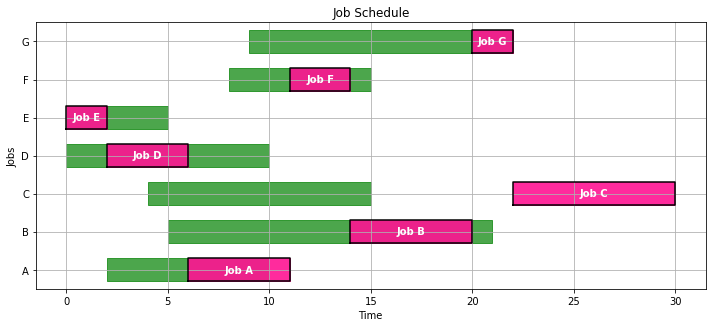

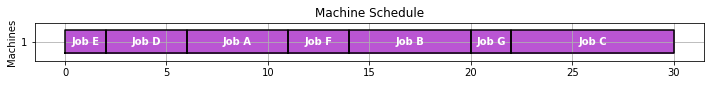

In [33]:
SCHEDULE = {}
for j in m.J:
  SCHEDULE[j] = {'thread': 1, 'start': m.start[j](), 'finish': m.start[j]() + JOBS[j]['duration']}

gantt(JOBS, SCHEDULE)
opt_output(JOBS, SCHEDULE)